# Оценка эффективности обогащения золотоносной руды


Подготовим прототип модели машинного обучения.
Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды на основании данных с параметрами добычи и очистки. 
Модель поможет оптимизировать производство.

In [1]:
import pandas as pd
import sklearn 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import warnings 
warnings.filterwarnings("ignore") 

# 1 Подготовим данные

## 1.1 Откроем файлы и изучим их

In [2]:
try:
    data_train = pd.read_csv('/Users/admin/Downloads/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/Users/admin/Downloads/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/Users/admin/Downloads/gold_recovery_full_new.csv')
except:
    data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')

    

In [3]:
print(data_train.sample(5))
print(data_test.sample(5))
print(data_full.sample(5))

                      date  final.output.concentrate_ag  \
3344   2016-06-28 22:59:59                     6.105955   
7570   2017-05-24 09:59:59                     4.891391   
12468  2018-05-25 20:59:59                     3.960730   
5311   2017-02-02 23:59:59                     5.149359   
10854  2018-03-08 16:59:59                     5.414371   

       final.output.concentrate_pb  final.output.concentrate_sol  \
3344                      5.866522                     10.460485   
7570                     10.297875                     10.739112   
12468                     9.181258                      7.593374   
5311                     11.314569                     16.187099   
10854                     8.441394                     10.524415   

       final.output.concentrate_au  final.output.recovery  \
3344                     47.232334              74.544864   
7570                     38.282744              68.727644   
12468                    47.680032              64.05

In [4]:
datasets = [data_train, data_test, data_full]

In [5]:
for i in datasets:
    print('-------------------------------------')
    i.info()

-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                 

In [6]:
for i in datasets:
    print (i.describe())

       final.output.concentrate_ag  final.output.concentrate_pb  \
count                 14148.000000                 14148.000000   
mean                      5.142034                    10.132960   
std                       1.369586                     1.654930   
min                       0.000000                     0.000000   
25%                       4.211620                     9.297355   
50%                       4.994652                    10.297144   
75%                       5.859540                    11.170603   
max                      16.001945                    17.031899   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                  13938.000000                 14149.000000   
mean                       9.202849                    44.003792   
std                        2.790516                     4.905261   
min                        0.000000                     0.000000   
25%                        7.484645                    4

''

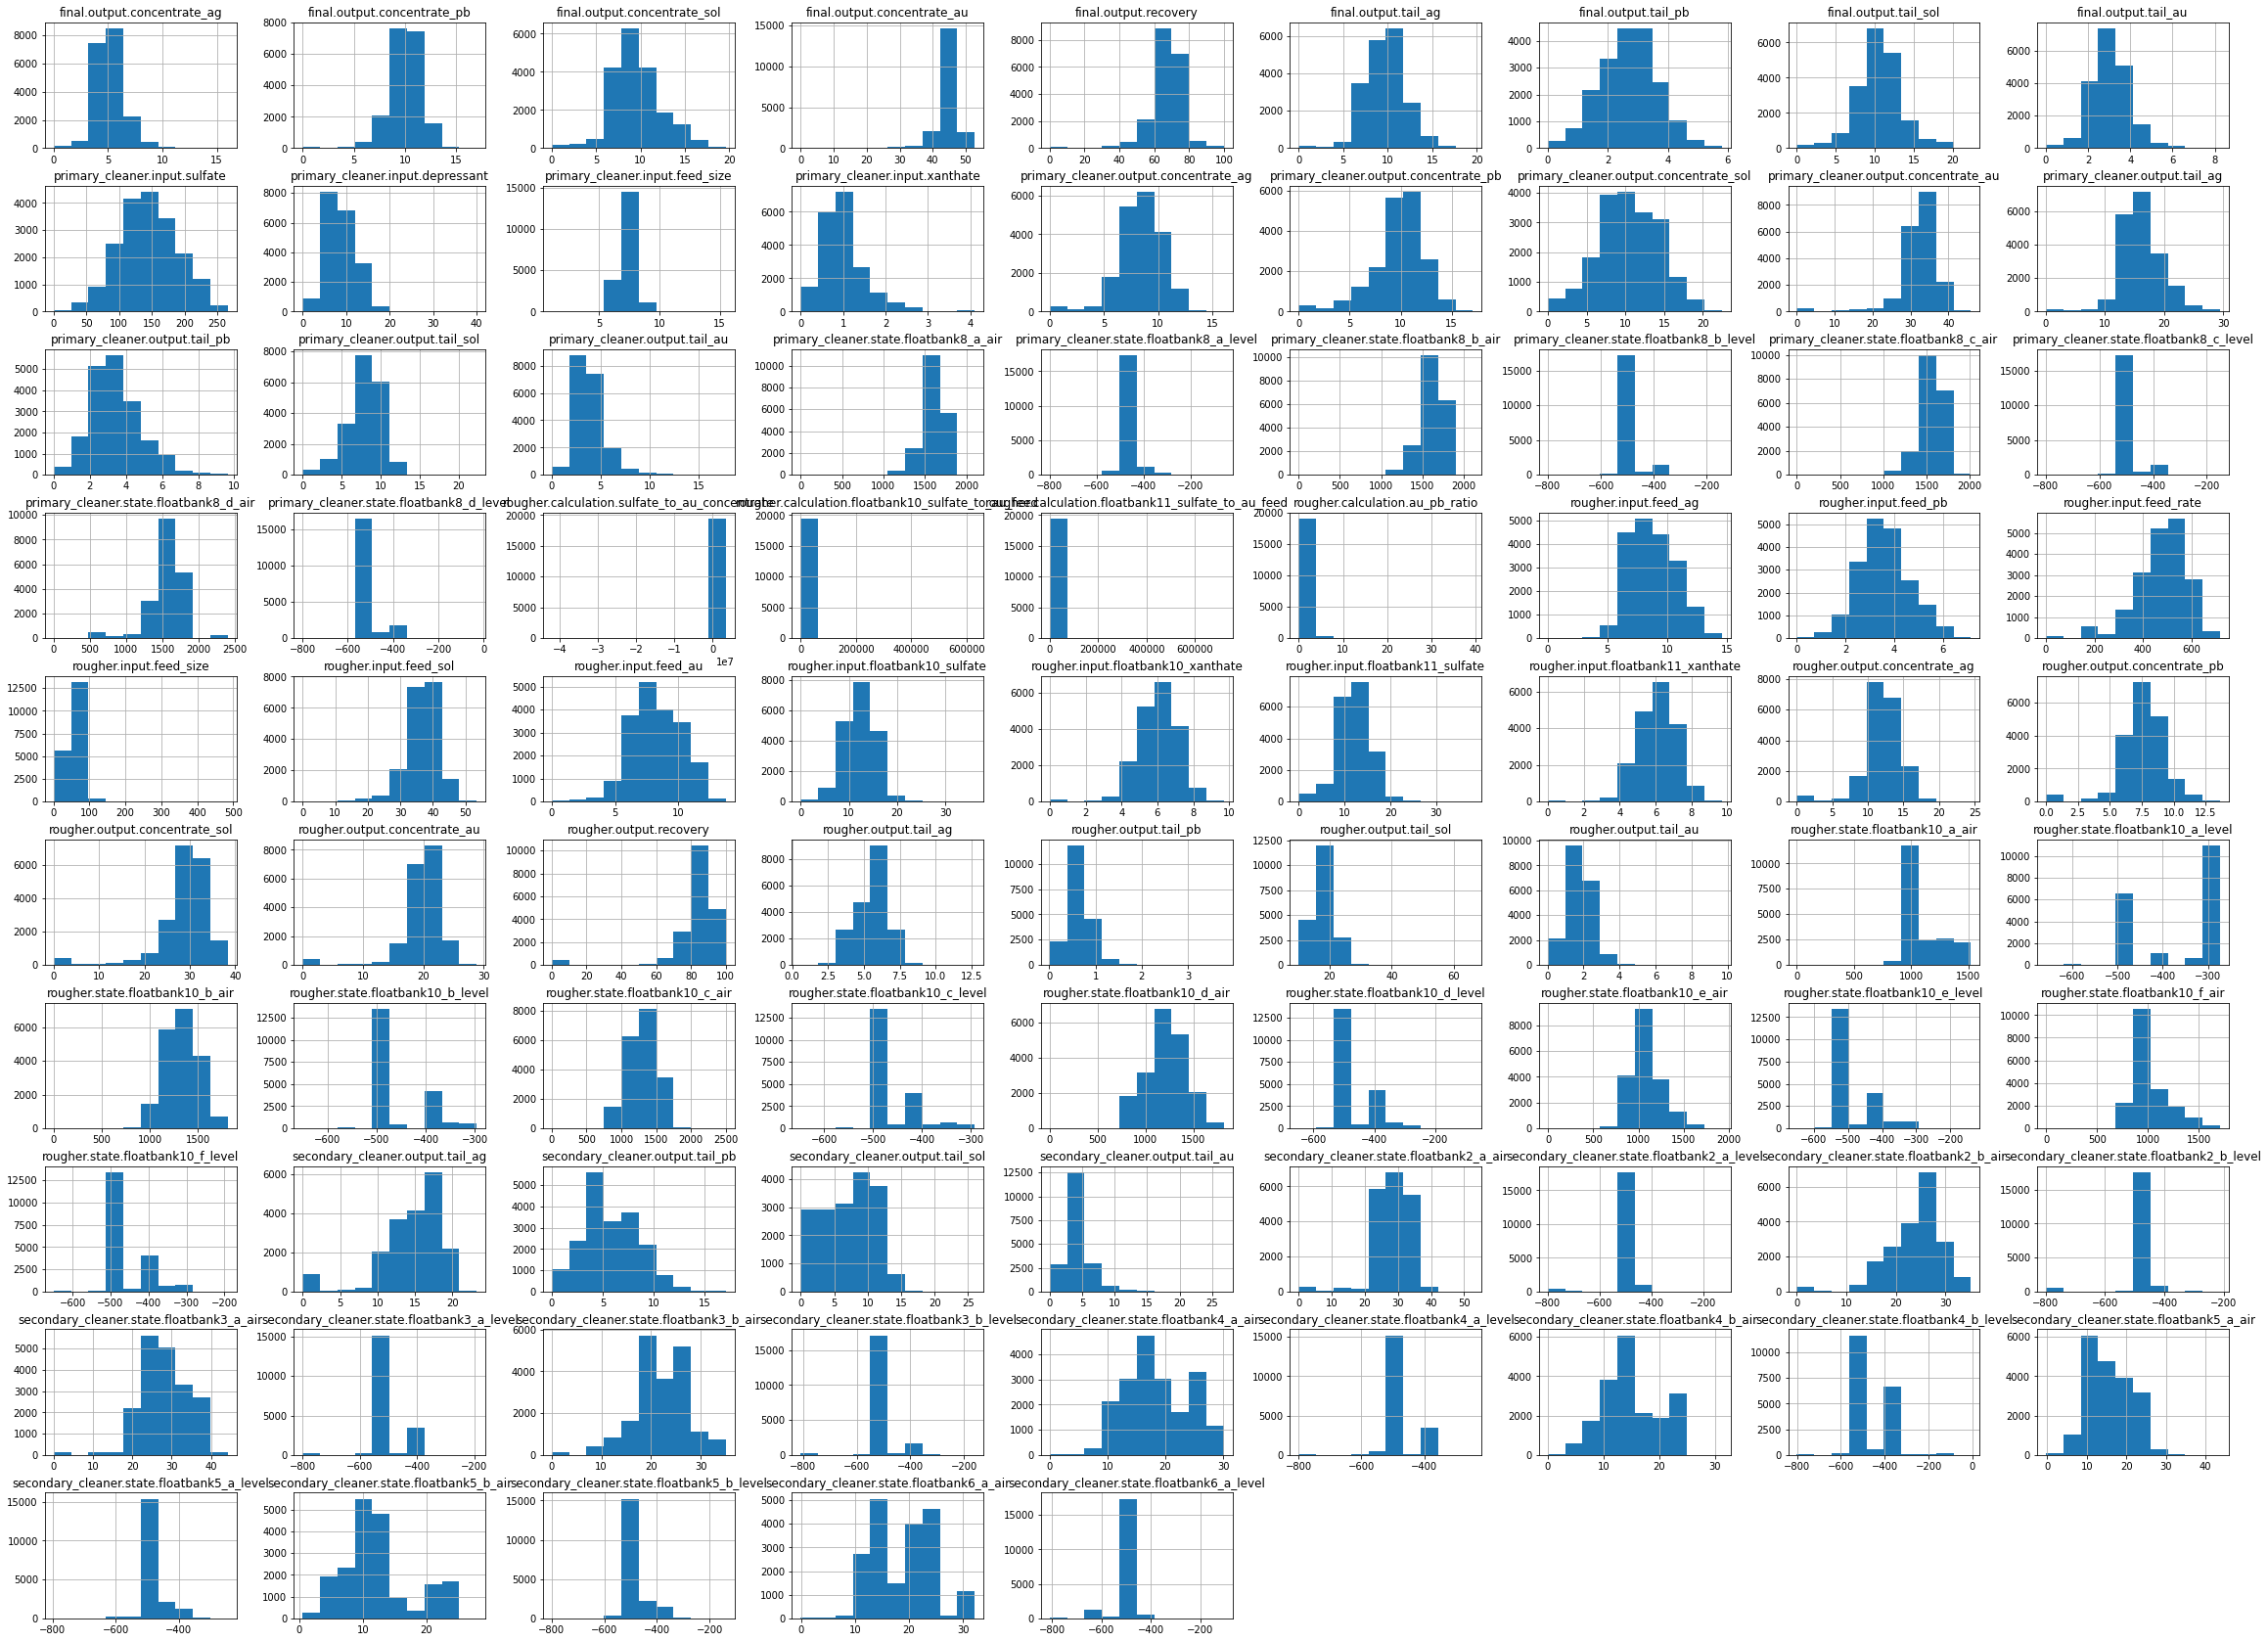

In [7]:
data_full.hist(figsize = (40,30))
;

По этим гистограммам можно сказать сразу, что есть признаки, являющиеся константами. Они явно не понадобятся для обучения моделей.

In [8]:
# Здесь огромная диаграмма корреляции, которая читается плохо
# upp_mat = np.triu(data_train.corr())
# sns.set(rc = {'figure.figsize':(40,40)})
# sns.heatmap(data_train.corr(), vmin = -1, vmax = +1, cmap = 'coolwarm', mask = upp_mat)


In [9]:
data_train.columns

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

In [10]:
data_test.columns

Index(['date', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level', 'rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'roughe

## 1.2 Проверим, что эффективность обогащения рассчитана правильно. 
Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между расчётами и значением признака.

In [11]:
data_train['rougher.output.recovery_est'] = (data_train['rougher.output.concentrate_au']\
                                         *(data_train['rougher.input.feed_au']- \
                                           data_train['rougher.output.tail_au'])*100)/\
(data_train['rougher.input.feed_au']*(data_train['rougher.output.concentrate_au'] - \
                                      data_train['rougher.output.tail_au']))

In [12]:
data_train[['rougher.output.recovery_est', 'rougher.output.recovery']]

,rougher.output.recovery_est,rougher.output.recovery
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14144,89.574376,89.574376
14145,87.724007,87.724007
14146,88.890579,88.890579
14147,89.858126,89.858126


In [13]:
# рассчитаем МАЕ
sklearn.metrics.mean_absolute_error(data_train['rougher.output.recovery_est'], data_train['rougher.output.recovery'])

1.1131451184435918e-14

Видим, что МАЕ очень мало, а значит рассчитанные нами значения почти полнстью совпали с данными в таблице.

## 1.3 Проанализируем признаки, недоступные в тестовой выборке.


In [14]:
drop_set = set(data_train.columns) - set(data_test.columns)
drop_set

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.recovery_est',
 'rougher.output.tail_ag',
 'rougher.outp

Почти все столбцы, отсутствующие в датасете test, относятся к типу output. Вероятно, еще не готовы ответы из лабаратории о содержании металлов. Также отсутствуют столбцы с рассчетными характеристиками, которые вероятнее всего основываются на этих отсутствующих данных.

## 1.4 Проведем предобработку данных.

In [15]:
data_train.isna().sum().sort_values(ascending = False).head(65)

secondary_cleaner.output.tail_sol                     1605
rougher.state.floatbank10_e_air                        436
rougher.input.floatbank11_xanthate                     428
primary_cleaner.output.concentrate_sol                 286
secondary_cleaner.state.floatbank2_a_air               217
                                                      ... 
rougher.calculation.sulfate_to_au_concentrate            1
rougher.calculation.floatbank10_sulfate_to_au_feed       1
secondary_cleaner.output.tail_au                         0
date                                                     0
rougher.output.concentrate_ag                            0
Length: 65, dtype: int64

In [16]:
data_test.isna().sum().sort_values(ascending = False).head(15)

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
dtype: int64

In [17]:
data_full.isna().sum().sort_values(ascending = False).head(65)

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
                                            ... 
primary_cleaner.state.floatbank8_d_level       1
rougher.output.tail_ag                         1
final.output.concentrate_pb                    1
final.output.tail_au                           0
rougher.calculation.au_pb_ratio                0
Length: 65, dtype: int64

Пропусков довольно много, удалить их - потеряем слишком много данных. 
Известно, что данные взаимосвязанны, т.е у близких точек будут схожие значения. В связи с этим будем заполнять пропуски предыдущим значением.

In [18]:
# Код ревьюера
data_train['rougher.input.feed_size'].describe()

count    14005.000000
mean        60.110518
std         22.418485
min          9.659576
25%         48.973027
50%         55.373885
75%         66.080172
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [19]:
for i in datasets:
    i.ffill(axis=None, inplace=True, limit=None, downcast=None)
    print (i.isna().sum().sort_values(ascending = False).head(15))

date                                 0
final.output.concentrate_ag          0
rougher.state.floatbank10_f_level    0
rougher.state.floatbank10_f_air      0
rougher.state.floatbank10_e_level    0
rougher.state.floatbank10_e_air      0
rougher.state.floatbank10_d_level    0
rougher.state.floatbank10_d_air      0
rougher.state.floatbank10_c_level    0
rougher.state.floatbank10_c_air      0
rougher.state.floatbank10_b_level    0
rougher.state.floatbank10_b_air      0
rougher.state.floatbank10_a_level    0
rougher.state.floatbank10_a_air      0
rougher.output.tail_au               0
dtype: int64
date                                          0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_d_level             0
rougher.state.floatbank10_e_air               0
rougher.state.floatbank10_e_level             0
rougher.state.floatbank10_f_air               0
rougher.state.floatbank10_f_level             0
secondary_cleaner.

От пропусков избавились.

In [20]:
for i in datasets:
    print(i.duplicated().sum())

0
0
0


Дубликатов нет

# 2. Проанализируем данные
Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки.

''

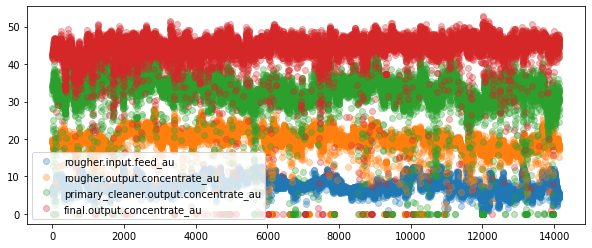

In [21]:
data_train[['rougher.input.feed_au', 'rougher.output.concentrate_au',
            'primary_cleaner.output.concentrate_au',
            'final.output.concentrate_au']].plot(style = 'o', alpha = (0.3), figsize = (10,4))
;

Такой графк выглядит не очень презентабельно, но на мой взгляд он очень нагляден. Можно проследить за любой точкой и как она менялась после каждой очистки.
Видно, что концентрация золота увеличивается в процессе очистки, что ожидаемо - в этом и состоит цель технологического процесса.

''

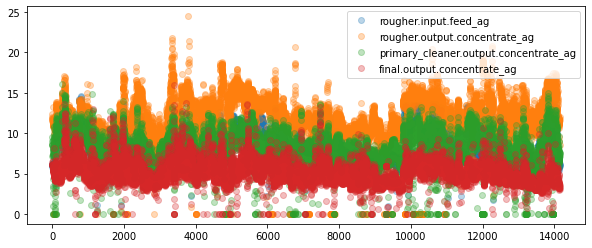

In [22]:
data_train[['rougher.input.feed_ag','rougher.output.concentrate_ag',
            'primary_cleaner.output.concentrate_ag',
            'final.output.concentrate_ag']].plot(style = 'o', alpha = (0.3), figsize = (10,4))
;

Концентрация серебра ожидаемо снижается

''

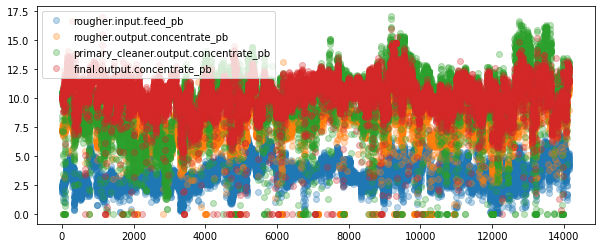

In [23]:
data_train[['rougher.input.feed_pb','rougher.output.concentrate_pb',
                                  'primary_cleaner.output.concentrate_pb',
                                  'final.output.concentrate_pb']].plot(style = 'o', alpha = (0.3), figsize = (10,4))
;

А вот концентарция свинца почти не меняется. После флотации она немного увеличилась, а потом оставалась приблзиительно на одном уровне. Можно предположить, что свинец отделяют от золота позже, напрмер в процессе плавления

In [24]:
data_train = data_train[data_train['rougher.input.feed_pb']>=0]

''

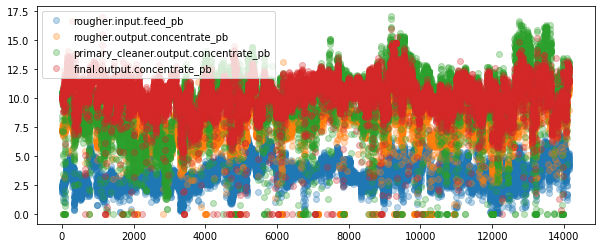

In [25]:
data_train[['rougher.input.feed_pb','rougher.output.concentrate_pb',
                                  'primary_cleaner.output.concentrate_pb',
                                  'final.output.concentrate_pb']].plot(style = 'o', alpha = (0.3), figsize = (10,4))
;

## 2.2  Сравним распределения размеров гранул сырья на обучающей и тестовой выборках.
Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

''

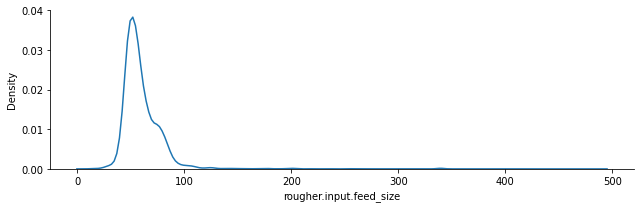

In [26]:
#figsize = (3,2)
sns.displot(data=data_train, x="rougher.input.feed_size", kind="kde", height = 3, aspect = 3)
;

''

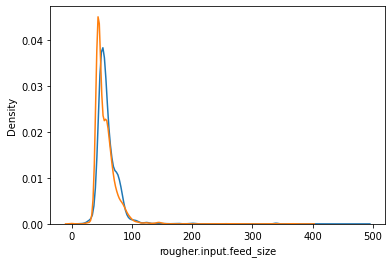

In [31]:
fig , ax = plt.subplots()
sns.kdeplot(data_train['rougher.input.feed_size'], ax=ax)
sns.kdeplot(data_test['rougher.input.feed_size'], ax=ax)
;

Возможно, стоило бы удалить и хвост вправо, но пока непонятно, какого размера гранулы могут быть максимально.

Проверка показала, что распределение у тренировочной и тестовой выборок идентичное. Здесь все в порядке

## 2.3 Исследуем суммарную концентрацию всех веществ на разных стадиях
В сырье, в черновом и финальном концентратах.


In [32]:
data_train['sum_conc_feed'] = (data_train['rougher.input.feed_au']
                                  + data_train['rougher.input.feed_ag'] 
                                  + data_train['rougher.input.feed_pb']
                                  + data_train['rougher.input.feed_sol'])

In [33]:
data_train['sum_conc_rougher'] = (data_train['rougher.output.concentrate_au']
                                  + data_train['rougher.output.concentrate_ag'] 
                                  + data_train['rougher.output.concentrate_pb']
                                  + data_train['rougher.output.concentrate_sol'])

In [35]:
data_train['sum_conc_final'] = (data_train['final.output.concentrate_au']
                                  + data_train['final.output.concentrate_ag'] 
                                  + data_train['final.output.concentrate_pb']
                                 + data_train['final.output.concentrate_sol'])

''

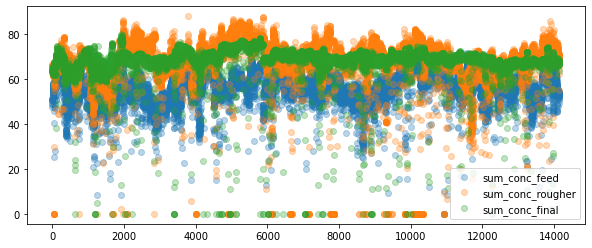

In [36]:
data_train[['sum_conc_feed', 'sum_conc_rougher', 'sum_conc_final']].plot(style = 'o', alpha = (0.3), figsize = (10,4))
;

У суммарной концентрации по мере очистки концентрата уменьшается разброс значений.

In [37]:
data_train = data_train[(data_train['sum_conc_feed']>10)
                        & (data_train['sum_conc_rougher'] > 10) 
                        & (data_train['sum_conc_final'] > 10) ]

<AxesSubplot:>

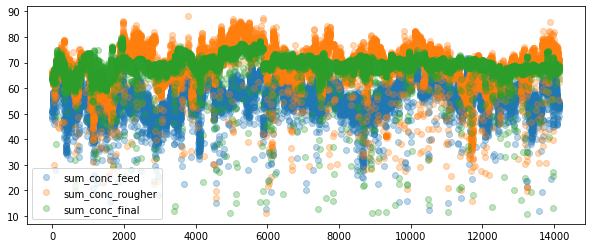

In [38]:
data_train[['sum_conc_feed', 'sum_conc_rougher', 'sum_conc_final']].plot(style = 'o',
                                                                         alpha = (0.3),
                                                                         figsize = (10,4));


# 3. Построим модель


Подготовим данные для обучения моделей. Для предсказания результатов флотации оставим только те данные, которые относятся к этому этапу. Из житейского опыта можно сказать точно, что результаты первой и второй очистки никак не могут повлиять на результаты черновой))
Также можно удалить графу с датой и временем, она тоже не даст никакой информации модели

In [39]:
#колонки для rougher
features_train_rougher = data_train[['rougher.input.feed_ag',
       'rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate', 'rougher.state.floatbank10_a_air',
       'rougher.state.floatbank10_a_level', 'rougher.state.floatbank10_b_air',
       'rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_air',
       'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_air',
       'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_air',
       'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_air',
       'rougher.state.floatbank10_f_level']]
features_train_rougher.shape

(13783, 22)

Получилось 22 колонки, уже лучше. Проверим корреляцию между признаками.

<AxesSubplot:>

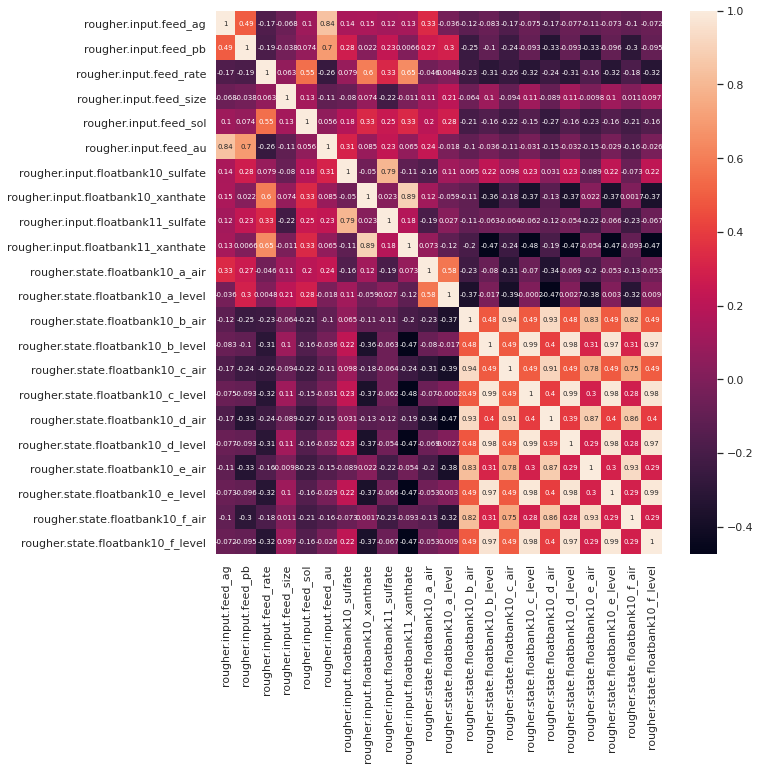

In [40]:

sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(features_train_rougher.corr(), annot=True, annot_kws={"size": 7})

По диаграмме видно, что есть сильно скоррелированные группы признаков. Они связаны с тех процессом. Из каждой группы оставим по одному признаку

In [41]:
features_train_rougher = features_train_rougher[['rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_level']]
features_train_rougher.shape

(13783, 13)

In [42]:
features_train_final = data_train[['primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level','rougher.input.feed_pb', 
       'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]

<AxesSubplot:>

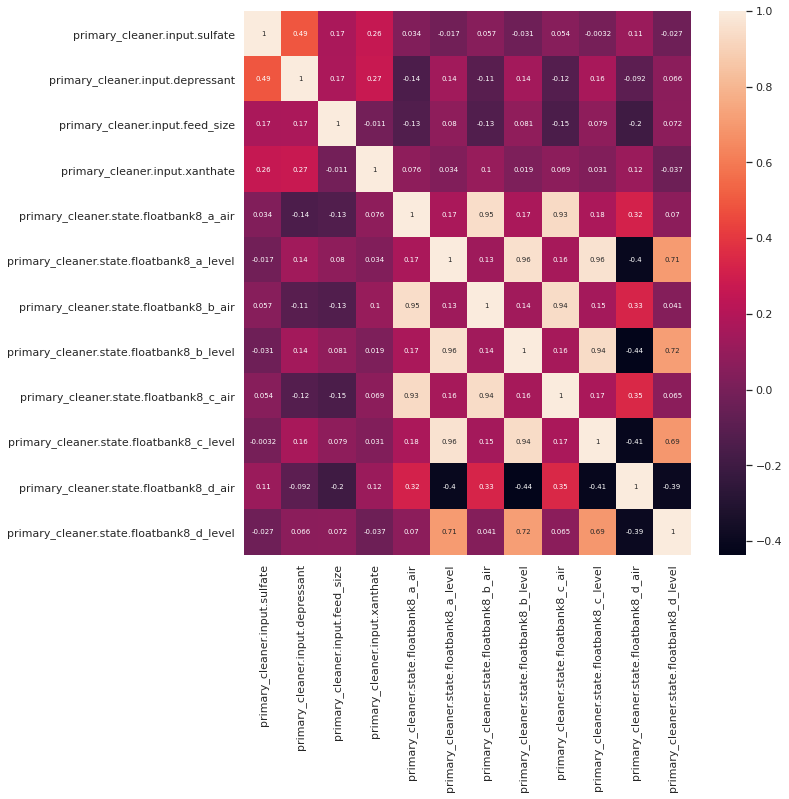

In [43]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(features_train_final[['primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state.floatbank8_c_air',
       'primary_cleaner.state.floatbank8_c_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level']].corr(), annot=True, annot_kws={"size": 7})

<AxesSubplot:>

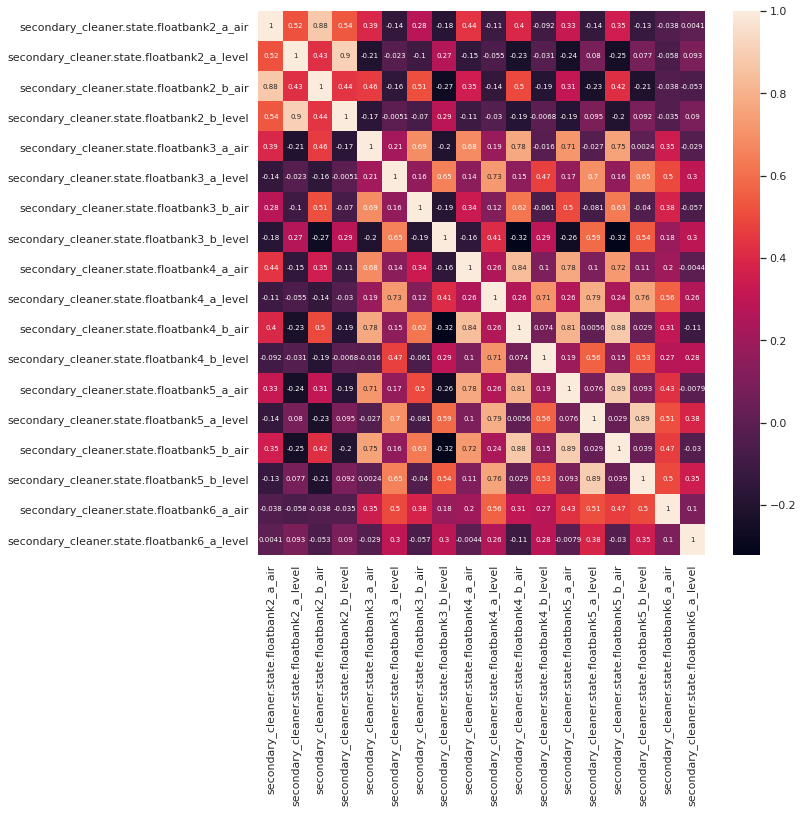

In [44]:
sns.set(rc = {'figure.figsize':(10,10)})
sns.heatmap(features_train_final[['secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_air',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_air',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank5_b_air',
       'secondary_cleaner.state.floatbank5_b_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']].corr(), annot=True, annot_kws={"size": 7})

Сильно скоррелированные признаки (k>0,8) удаляем, оставляем только по одному из группы

In [45]:
features_train_final = data_train[['primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level','rougher.input.feed_pb', 
       'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]
features_train_final.shape

(13783, 35)

In [46]:
features_test_final = data_test[['primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_d_air',
       'primary_cleaner.state.floatbank8_d_level','rougher.input.feed_pb', 
       'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_level',
       'secondary_cleaner.state.floatbank2_a_air',
       'secondary_cleaner.state.floatbank2_a_level',
       'secondary_cleaner.state.floatbank2_b_air',
       'secondary_cleaner.state.floatbank2_b_level',
       'secondary_cleaner.state.floatbank3_a_air',
       'secondary_cleaner.state.floatbank3_a_level',
       'secondary_cleaner.state.floatbank3_b_air',
       'secondary_cleaner.state.floatbank3_b_level',
       'secondary_cleaner.state.floatbank4_a_air',
       'secondary_cleaner.state.floatbank4_a_level',
       'secondary_cleaner.state.floatbank4_b_level',
       'secondary_cleaner.state.floatbank5_a_level',
       'secondary_cleaner.state.floatbank6_a_air',
       'secondary_cleaner.state.floatbank6_a_level']]
features_test_final.shape

(5290, 35)

Есть также идея, что вообще-то весь техпроцесс должен быть отлажен. И недоработки в части технологии не должны влиять на полученные результаты.
По сути на результат должны влиять только параметры сырья.

Второй набор обучающих данных для rougher  - столбцы 
'rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au'

Сделаем по два эксперимента для моделей: с тремя признаками на входе и с 22мя. Посмотрим, какая метрика нас больше устроит.

In [47]:
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']

In [48]:
features_train_min = data_train[['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au']]

Для тестовой выборки возьмем значения целевого признака из полного датасета, data_full

In [49]:
date_l = list(data_test['date'])

In [50]:
data_test_2 = data_full.query('date in @date_l')

In [51]:
target_test_rougher = data_test_2['rougher.output.recovery']
target_test_final = data_test_2['final.output.recovery']

In [52]:
features_test_rougher = data_test_2[['rougher.input.feed_pb', 'rougher.input.feed_rate',
       'rougher.input.feed_size', 'rougher.input.feed_sol',
       'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate',
       'rougher.input.floatbank10_xanthate',
       'rougher.input.floatbank11_sulfate',
       'rougher.input.floatbank11_xanthate',
        'rougher.state.floatbank10_a_air',
        'rougher.state.floatbank10_f_air',
        'rougher.state.floatbank10_a_level',
       'rougher.state.floatbank10_f_level']]

In [53]:
features_test_min = data_test_2[['rougher.input.feed_ag','rougher.input.feed_pb','rougher.input.feed_au']]

Итак, наша цель - две наилучшие модели для двух целевых признаков. Будем использовать следующие данные:

1 Обучающие признаки: 

    1.1 features_train_min и features_test_min - для обучения на данных о сырье

    1.2 features_train_rougher и features_test_rougher - для обучения черновой модели
        features_train_final и features_test_final - для финальной модели


2 Целевой признак:

    2.1 для чернового концентрата:
    
    target_train_rougher и
    target_test_rougher

    2.2 Для финального концентрата:

    target_train_final и 
    target_test_final

## 3.1 Подготовим функцию sMAPE

In [54]:
def sMAPE(target, predictions):
    smape = 2*100*abs(target-predictions)/(abs(target)+abs(predictions))
    smape = smape.fillna(value = 0)
    smape = np.mean(smape)
    return smape

Создаем объект для оценки

In [55]:
smape_scorer = make_scorer(sMAPE,greater_is_better = False) #

## 3.2 Обучим разные модели и оценим их качество кросс-валидацией. 

Для обучения выбраны три типа моделей - DecisionTreeRegressor, RandomForestRegressor и LinearRegression. Как основу для сравнениия возьмем простейшую модель DummyRegressor.
Начнем с дамми и линейной регрессиии. Для них не нужно подбирать гиперпараметры, используем cross_val_score для оценки качества модели с помощью кроссвалидации

In [94]:
dummy_model_min = DummyRegressor(strategy = 'median')
#Для чернового концентрата
scores_roug = cross_val_score(dummy_model,features_train_min,target_train_rougher, cv=5, 
                             scoring = smape_scorer)
sMAPE_rougher = (sum(scores_roug)/len(scores_roug)).round(1)*(-1)
print('Dummy модель')
print('Для чернового концентрата sMAPE:',sMAPE_rougher)
#Для финального
scores_fin = cross_val_score(dummy_model, features_train_min,target_train_final, cv=5, 
                             scoring = smape_scorer)
sMAPE_final = (sum(scores_fin)/len(scores_fin)).round(1)*(-1)
print('Для финального концентрата sMAPE:',sMAPE_final)

Dummy модель
Для чернового концентрата sMAPE: 7.8
Для финального концентрата sMAPE: 10.4


In [95]:
print('Итоговое sMAPE:')
print(0.25*sMAPE_rougher + 0.75*sMAPE_final)

Итоговое sMAPE:
9.75


### 3.2.1 На трех признаках:

In [61]:
linear_model_1 = LinearRegression()
scores = cross_val_score(linear_model_1,features_train_min,target_train_rougher, cv=5, 
                             scoring = smape_scorer)
print('Для линейной модели:')
print('Для чернового концентрата sMAPE:',(sum(scores)/len(scores))*(-1))


linear_model_2 = LinearRegression() 
scores = cross_val_score(linear_model_2,features_train_min,target_train_final, cv=5, 
                             scoring = smape_scorer)
print('Для финального концентрата sMAPE:',(sum(scores)/len(scores))*(-1))

Для линейной модели:
Для чернового концентрата sMAPE: 7.065696646946611
Для финального концентрата sMAPE: 10.172362889034549


Для DecisionTreeRegressor и RandomForestRegressor будем подбирать гиперпараметры с помощью GridSearch, выбирать наилучшие будем по нашей метрике sMAPE

In [62]:
# Для решающего дерева
parameters_tr = {'max_depth' : range(1,100,2)}

tr_grid = GridSearchCV(DecisionTreeRegressor(random_state=12345),
                       param_grid = parameters_tr,
                      n_jobs = -1, 
                       verbose = False, 
                       scoring = smape_scorer)



In [66]:
%%time

tr_grid_model_1 = tr_grid.fit(features_train_min, target_train_rougher)
print('Для решающего дерева:')
print('Черновой концентрат:')
print(tr_grid_model_1.best_estimator_)
print(tr_grid_model_1.best_score_)
tr_grid_model_2 = tr_grid.fit(features_train_min, target_train_final)
print('Финальный концентрат:')
print(tr_grid_model_2.best_estimator_)
print(tr_grid_model_2.best_score_)

Для решающего дерева:
Черновой концентрат:
DecisionTreeRegressor(max_depth=3, random_state=12345)
-6.805446675268139
Финальный концентрат:
DecisionTreeRegressor(max_depth=1, random_state=12345)
-9.60436022738085
CPU times: user 26.9 s, sys: 96.9 ms, total: 27 s
Wall time: 27 s


Отрицательные значения получаем в связи с особенностями работы make_scorer, их можно просто домножиить на (-1) или взять по модулю

In [76]:
# Для леса
parameters_fr = {'max_depth' : range(1,21,2),
                 'n_estimators' : range(1,21,2)}

fr_grid = GridSearchCV(RandomForestRegressor(random_state=12345), 
                       param_grid = parameters_fr,
                      n_jobs = -1, 
                       verbose = False, 
                       cv = 3, 
                       scoring = smape_scorer)



In [68]:
%%time
fr_grid_model_1 = fr_grid.fit(features_train_min, target_train_rougher)

print('Для леса')
print('Черновой конентрат')
print(fr_grid_model_1.best_estimator_)
print(fr_grid_model_1.best_score_)

fr_grid_model_2 = fr_grid.fit(features_train_min, target_train_final)

print('Финальный концентрат')
print(fr_grid_model_2.best_estimator_)
print(fr_grid_model_2.best_score_)

Для леса
Черновой конентрат
RandomForestRegressor(max_depth=1, n_estimators=19, random_state=12345)
-7.921012344269921
Финальный концентрат
RandomForestRegressor(max_depth=1, n_estimators=19, random_state=12345)
-9.887288079517917
CPU times: user 1min 32s, sys: 245 ms, total: 1min 32s
Wall time: 1min 33s


На выборке из трех признаков получены следующие результаты sMAPE:
Линейная 7; 10.2
Дерево 6.8; 9.6
Лес 7.9; 9.8
Для сравнениия, дамми 7.8; 10.4

Проверим на тестовой выборке лучшую модель - решающее дерево

In [92]:
best_model_min_rougher = DecisionTreeRegressor(max_depth = 3,random_state=12345)
best_model_min_rougher.fit(features_train_min, target_train_rougher)
sMAPE_rougher = sMAPE(target_test_rougher, best_model_min_rougher.predict(features_test_min))
print(sMAPE_rougher)

best_model_min_final = DecisionTreeRegressor(max_depth = 1,random_state=12345)
best_model_min_final.fit(features_train_min, target_train_final)
sMAPE_final = sMAPE(target_test_final, best_model_min_final.predict(features_test_min))
print(sMAPE_final)


8.339502586333765
9.601682177346623


In [93]:
print('Итоговое sMAPE:')
print(0.25*sMAPE_rougher + 0.75*sMAPE_final)

Итоговое sMAPE:
9.286137279593408


### 3.2.2 Теперь выберем лучшую модель, обучая на более полном наборе признаков

In [81]:
linear_model_1 = LinearRegression()
scores = cross_val_score(linear_model_1,features_train_rougher,target_train_rougher, cv=5, 
                             scoring = smape_scorer)
print('Для линейной модели:')
print('Для чернового концентрата sMAPE:',(sum(scores)/len(scores))*(-1))


linear_model_2 = LinearRegression() 
scores = cross_val_score(linear_model_2,features_train_final,target_train_final, cv=5, 
                             scoring = smape_scorer)
print('Для финального концентрата sMAPE:',(sum(scores)/len(scores))*(-1))

Для линейной модели:
Для чернового концентрата sMAPE: 6.666704678534467
Для финального концентрата sMAPE: 10.508821163331891


In [78]:
%%time

tr_grid_model_1 = tr_grid.fit(features_train_rougher, target_train_rougher)
print('Для решающего дерева:')
print('Черновой концентрат:')
print(tr_grid_model_1.best_estimator_)
print(tr_grid_model_1.best_score_)
tr_grid_model_2 = tr_grid.fit(features_train_final, target_train_final)
print('Финальный концентрат:')
print(tr_grid_model_2.best_estimator_)
print(tr_grid_model_2.best_score_)

Для решающего дерева:
Черновой концентрат:
DecisionTreeRegressor(max_depth=3, random_state=12345)
-7.412296128855068
Финальный концентрат:
DecisionTreeRegressor(max_depth=1, random_state=12345)
-10.109316177385193
CPU times: user 3min, sys: 405 ms, total: 3min
Wall time: 3min 1s


In [79]:
%%time
fr_grid_model_1 = fr_grid.fit(features_train_rougher, 
                              target_train_rougher)

print('Для леса')
print('Черновой конентрат')
print(fr_grid_model_1.best_estimator_)
print(fr_grid_model_1.best_score_)

fr_grid_model_2 = fr_grid.fit(features_train_final, 
                              target_train_final)

print('Финальный концентрат')
print(fr_grid_model_2.best_estimator_)
print(fr_grid_model_2.best_score_)

Для леса
Черновой конентрат
RandomForestRegressor(max_depth=5, n_estimators=3, random_state=12345)
-7.695745796407864
Финальный концентрат
RandomForestRegressor(max_depth=1, n_estimators=1, random_state=12345)
-10.64705240731796
CPU times: user 10min 25s, sys: 1.59 s, total: 10min 27s
Wall time: 10min 29s


На бОльшей выборке получены следующие результаты sMAPE:
Линейная 6.7; 10.5
Дерево 7.4; 10.1
Лес 7.7; 10.6
Для сравнениия, дамми 7.8; 10.4

In [89]:
best_model_rougher = linear_model_1.fit(features_train_rougher, target_train_rougher)
sMAPE_rougher = sMAPE(target_test_rougher, best_model_rougher.predict(features_test_rougher))
print(sMAPE_rougher)

8.047589359923835


In [90]:
best_model_final = DecisionTreeRegressor(max_depth = 1,random_state=12345)
best_model_final.fit(features_train_final, target_train_final)
sMAPE_final = sMAPE(target_test_final, best_model_final.predict(features_test_final))
print(sMAPE_final)


9.393786208619916


In [91]:
print('Итоговое sMAPE:')
print(0.25*sMAPE_rougher + 0.75*sMAPE_final)

Итоговое sMAPE:
9.057236996445896


In [ ]:
# linear_model_1.fit(features_train, target_train_rougher)
# linear_model_2.fit(features_train, target_train_final)

# predict_rougher = linear_model_1.predict(features_test)
# predict_final = linear_model_2.predict(features_test)

# sMAPE_rougher = sMAPE(target_test_rougher,predict_rougher)
# sMAPE_final = sMAPE(target_test_final,predict_final)
# print(sMAPE_rougher)
# print(sMAPE_final)

# 4 Вывод
В ходе выполнения проекта были изучены предоставленные данные, проверено, что эффективность рассчитана правильно.

Произведен анализ признаков, отсутствующих в тестовой выборке. Предпоалагаем, что данные лабараторных исследований еще не получены.

Данные проверены на наличие пропусков и дубликатов. Пропуски заполнены ближайшими значениями, т.к известно, что данные взаимосвязаны и близкие по времени замеры будут схожими.

Визуализриованны изменения концентрации веществ. Видно, что концентрация золота растет, серебро отделяется в ходе очистки, а свинец остается с золотом.

Проверено, что распределение у тренировочной и тестовой выборок идентичное.

Исследованна суммарная концентрация всех веществ. Удалены нулевые значения - скорее всего, это сбой измерительного оборудования.

Сформированно два набора данных для обучения моделей - малый, состоящий из трех признаков, характеризуюих сырье, и бОльший, который содержит данные о технологическом процессе.

На этих данных обучались три модели - LinearRegression, DecisionTreeRegressor, RandomForestRegressor. Эффективность оцениивалась с помощью метрики sMAPE. Получены следующие результаты:

Лучший результат для малого набора признаков: 9.3

Лучший результат для большего набора признаков 9.0

При этом результат простой модели (dummy): 9.7


Видим, что результаты обученных моделей мало отличаются от результатов предсказания медианой. Это низкое качество моделей.

Предполагаем, что предоставленные данные мало пригодны для обучения моделей.